<a href="https://colab.research.google.com/github/Alexey1998-ml/example/blob/master/Copy_of_catch_me.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score,\
learning_curve, TimeSeriesSplit
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import torch
import torch.nn as nn
from IPython.display import clear_output
import re
import pickle
from gensim.models import FastText
from gensim.test.utils import get_tmpfile
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
colab = True
if colab:
    PATH_TO_TRAIN = 'drive/My Drive/catch_me_test_sessions.csv'
    PATH_TO_TEST = 'drive/My Drive/catch_me_train_sessions.csv'
    PATH_TO_PICKLE = 'drive/My Drive/site_dic.pkl'
    PATH_TO_TF_IDF = 'drive/My Drive/tf_idf_embeddings.csv'
else:
    PATH_TO_TRAIN = 'catch_me_test_sessions.csv'
    PATH_TO_TEST = 'catch_me_train_sessions.csv'
    PATH_TO_PICKLE = '../site_dic.pkl'
PREDICT_FILENAME = 'catch_me_preds.csv'
test = pd.read_csv(PATH_TO_TRAIN)
data = pd.read_csv(PATH_TO_TEST)
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]
data = data.drop_duplicates(subset = sites)
data = data.reset_index().drop(['session_id', 'index'], axis = 1)
data['index'] = [i for i in data.index]
data_tfidf = pd.read_csv(PATH_TO_TF_IDF)
data_tfidf.columns = [f'tf_idf_{i}' for i in range(128)]
data = pd.concat([data,data_tfidf], axis = 1)

In [0]:
with open(PATH_TO_PICKLE, 'rb') as f:
    sites_dict = pickle.load(f)

In [0]:
sites_dict['padding'] = 0
id_sites_dict = {sites_dict[site_name]:site_name for site_name in sites_dict}

after_dot = Counter()
for site_name in sites_dict:
    after_dot.update({site_name.split('.')[-1]})

after_dot = set(dict(after_dot.most_common(35)).keys())

In [0]:
corrected_site_name = []
for id_site in id_sites_dict:
    array_site_name = id_sites_dict[id_site].split('.')
    if array_site_name[0] == 'www':
        del array_site_name[0]
    if array_site_name[-1] in after_dot:
        del array_site_name[-1]
    id_sites_dict[id_site] = '.'.join(array_site_name)

In [0]:
data.fillna(0, inplace = True)
test.fillna(0, inplace = True)
data[sites] = data[sites].applymap(lambda id: id_sites_dict[id])
test[sites] = test[sites].applymap(lambda id: id_sites_dict[id])

In [0]:
model_ft = FastText.load('drive/My Drive/ft_model.model')
clustering_model = None

In [0]:
def roc_auc (model, data, predict = True, target = 'target', batch = None, prob = 1):
    # data = data.sample(int(data.shape[0] * prob))
    if not batch:
      batch = trainer.make_batch(data, predict = predict)
    roc_auc = roc_auc_score(data[target],
                            model(torch.tensor(batch['cat']).float().cuda(),
                                  torch.tensor(batch['cluster']).float().cuda()).cpu().data.numpy())
    return roc_auc

class MyAttention(nn.Module):
    def __init__(self, hid_size):
        
        super(MyAttention, self).__init__()
        self.hid_size = hid_size
        self.relu = nn.ReLU()
        att_weights = nn.Parameter(torch.Tensor(1, hid_size), requires_grad = True)
        std = 1 / np.sqrt(hid_size)
        self.att_weights = nn.init.uniform_(att_weights, -std, std)
  
    def forward (self, input):
        batch_size = input.size(0)

        weights = torch.bmm(input,
                            self.att_weights            # 1, hid_size
                            .permute(1,0)               # hid_size , 1
                            .unsqueeze(0)               # 1, hid_size, 1
                            .repeat(batch_size, 1,1)    # batch_size , hid_size, 1
                            )    
        attention = torch.softmax(self.relu(weights.squeeze()), dim = -1)
        weights = torch.mul(input, attention.unsqueeze(-1))
        representation = weights.sum(1)
        return representation

    

In [0]:
class Prepare:
    def __init__(self, train, test, clustering_model, target_column : str = 'target', model_ft = model_ft, **kwargs):
        self.train = train
        self.test = test
        self.target_column = target_column
        self.target = train[target_column]
        self.unknown_idx = -1
        self.pad_idx = 0
        self.test_size = 0.15
        self.batch_size = 1024
        self.dropout = 0.5
        self.number_sites = 40000
        self.clustering_mean = False
        self.model_ft = model_ft
        self.clustering_model = clustering_model
        self.clustering_tf_idf = True
        self.range_clustering = range(5, 50, 5)

    def _get_vector(self, x):
       return self.model_ft[x]


    def prepare_df (self):
        train = self.train
        test = self.test
        train[times] = train[times].apply(pd.to_datetime)
        test[times] = test[times].apply(pd.to_datetime)
        train = train.sort_values('time1')
        train = self._create_cat_features(train)
        test = self._create_cat_features(test)
        if self.clustering_mean:
          train, test = self._add_mean_embedding_column(train, test)
        self.train = train
        self.test = test
        self.sites_to_id = False


    def _add_mean_embedding_column(self, train, test):
        self.mean_embedding_columns = [f'mean_embeding_{idx}' for idx in range(128)]
      
        mean_embeddings_train = np.array(list(map(self._get_vector,train[sites].values))).mean(axis = 1)
        for idx, col in enumerate(self.mean_embedding_columns):
          train[col] = mean_embeddings_train[:, idx]

        mean_embeddings_test = np.array(list(map(self._get_vector,test[sites].values))).mean(axis = 1)
        for idx, col in enumerate(self.mean_embedding_columns):
          test[col] = mean_embeddings_test[:, idx]
        return train, test


    def _get_known_sites(self, train, number_sites = 5000):
        counter = Counter()
        alice_sites = Counter()
        for site in sites:
            for num_site in train[site]:
                counter.update({num_site})
        for site in sites:
            for num_site in train[train['target'] == 1][site]:
                alice_sites.update({num_site})
        known_sites = [site for site, counts in dict(counter.most_common(self.number_sites)).items()]
        known_sites += [site for site, counts in alice_sites.items()]
        known_sites += [self.pad_idx, self.unknown_idx]
        known_sites = set(known_sites)
        sites_to_id = {site : inx for inx, site in enumerate(known_sites)}
        self.id_unknown_idx = sites_to_id[self.unknown_idx]
        self.sites_to_id = sites_to_id
        return sites_to_id


    def get_df_for_train(self):
        train_df, valid_df, train_target, valid_target = train_test_split(self.train, self.target, random_state = 42,
                                                                          shuffle = False, test_size = self.test_size)
        if self.clustering_mean:
          if self.clustering_model is None:
            self._make_clustering_model(train_df, self.mean_embedding_columns)
          train_df = self._add_clustering_features(train_df)
          valid_df = self._add_clustering_features(valid_df)
         
        if self.clustering_tf_idf:
          self.tf_idf_embedding = list(filter(lambda col: col[:6] == 'tf_idf', train_df.columns))
          if self.clustering_model is None:
            self._make_clustering_model(train_df, self.tf_idf_embedding)
          train_df = self._add_clustering_features(train_df)
          valid_df = self._add_clustering_features(valid_df)
        
        self.clustering_columns = list(filter(lambda col: col[:4] == 'clus', train_df.columns))

        return train_df, valid_df, self.clustering_model
    



    def _create_cat_features(self, df):
        cat = 'cat_'
        df[f'{cat}hour'] = df['time1'].apply(lambda time: time.hour)
        df[f'{cat}morning'] = ((df[f'{cat}hour'] >= 7) & (df[f'{cat}hour'] <= 11)).astype('int')
        df[f'{cat}day'] = ((df[f'{cat}hour'] >= 12) & (df[f'{cat}hour'] <= 18)).astype('int')
        df[f'{cat}evening'] = ((df[f'{cat}hour'] >= 19) & (df[f'{cat}hour'] <= 23)).astype('int')
        df[f'{cat}day_of_week'] = df['time1'].apply(lambda t: t.weekday()).astype('int')
        self.cat_feature_for_mean_target = [f'{cat}day_of_week', f'{cat}hour']
        for cat_feature in self.cat_feature_for_mean_target:
          df = pd.concat([df, pd.get_dummies(df[cat_feature], prefix = cat_feature)], axis = 1)
          df.drop([cat_feature], axis = 1, inplace = True)
        self.cat_columns = list(filter(lambda col: col[:4] == 'cat_', df.columns))
        return df


    def _mean_target_encoding (self, train_df, valid_df, column_name : str, alpha = 10):
        global_mean = train_df[self.target_column].mean()
        average = train_df[[self.target_column, column_name]].groupby(by = column_name).agg(['mean', 'count'])[self.target_column]
        smoothly = (average['mean'] * average['count'] + alpha * train_df['target'].mean()) / (average['count'] + alpha)
        train_df[column_name] = train_df[column_name].map(smoothly)
        valid_df[column_name] = valid_df[column_name].map(smoothly)
        scaler = StandardScaler().fit(train_df[column_name].values.reshape(-1,1))
        train_df[column_name] = scaler.transform(train_df[column_name].values.reshape(-1,1))
        valid_df[column_name] = scaler.transform(valid_df[column_name].values.reshape(-1,1))
        return train_df, valid_df


    def _make_clustering_model(self, train_df, columns_for_clustering, mode):
      if self.clustering_model is None:
        self.clustering_model = {}
      for idx, num_clusters in enumerate(self.range_clustering):
        self.clustering_model[f'{mode}_{idx}'] = KMeans(n_clusters = num_clusters, 
                                                        random_state = 10).fit(train_df[self.columns_for_clustering])


    def _add_clustering_features(self, df, mode):
      for key in list(filter(lambda mode_model: mode_model.split('_')[0] == mode, self.clustering_model.keys()):
        idx = key.split('_')[-1]
        model = self.clustering_model[key]
        df[f'clustering_{mode}_{idx}'] = model.predict(df[self.columns_for_clustering])
        df = pd.concat([df, pd.get_dummies(df[f'clustering_{idx}'],
                                          prefix = f'clustering_{idx}')], axis = 1)
        df.drop(f'clustering_{mode}_{idx}', axis = 1, inplace = True)
      return df

    def _get_df_for_test(self):
        test = self.test
        sites_to_id = self.sites_to_id
        test[sites] = test[sites].applymap(lambda num_site: sites_to_id[num_site] if num_site in sites_to_id 
                                           else sites_to_id[self.unknown_idx])
        self.test = test
        return test
    
    def get_train_df(self):
        train = self.train
        sites_to_id = self._get_known_sites(train)
        self.sites_to_id = sites_to_id
        train[sites] = train[sites].applymap(lambda num_site: sites_to_id[num_site] if num_site in sites_to_id 
                                           else sites_to_id[self.unknown_idx])
        self.train = train
        return train
    

In [0]:
class TrainNN(Prepare):
    
    def make_batch (self, df, dropout = 0, predict = False, **kwargs):
        if 'is_test' in kwargs:
            is_test = kwargs['is_test']
        else:
            is_test = False
        if self.dropout:
            dropout = self.dropout
            
        batch = {}
        # major_matrix = np.array(list(map(get_vector,df[sites].values)))
        # batch['sites'] = major_matrix
        # if dropout > 0 and not predict:
        #     batch['sites'] = self._apply_word_dropout(batch['sites'], dropout, self.id_unknown_idx)
        batch['sites'] = 1
        

        if not is_test:
            batch[self.target_column] = df[self.target_column].values
            
        batch['cat'] = df[self.cat_columns].values
        batch['cluster'] = df[self.clustering_columns].values

        return batch

    def _apply_word_dropout (self, matrix, keep_prop, replace_with = -1, pad_ix = 0):
        dropout_mask = np.random.choice(2, matrix.shape, p = [1 - keep_prop, keep_prop])
        dropout_mask &= matrix !=  pad_ix
        return np.choose (dropout_mask, [matrix, np.full_like(matrix, replace_with)])
    
    def iterable_minibatches (self, data, shuffle = True, **kwargs):
        indecses = np.arange(len(data))
        if shuffle:
            indecses = np.random.permutation(indecses)
        for start in range(0, len(indecses), self.batch_size):
            batch = self.make_batch(data.iloc[indecses[start : start + self.batch_size]], **kwargs)
            target = batch.pop(self.target_column)
            yield batch, target
    
    def make_predictions_file (self, model):
        test = self._get_df_for_test()
        batch = self.make_batch(test, predict = True, is_test = True)
        input_site = torch.tensor(batch['sites'], dtype=torch.long).cuda()
        input_cat = torch.tensor(batch['cat'], dtype=torch.long).float().cuda()
        predictions = model(input_site, input_cat).cpu().data.numpy()
        series_preds = pd.Series(predictions[:,0], index = range (1,predictions[:,0].shape[0] + 1),
                  name = 'target')
        series_preds.to_csv(PREDICT_FILENAME, header = True, index_label = 'session_id')

In [0]:
trainer = TrainNN(data, test, clustering_model = clustering_model)

In [0]:
trainer.prepare_df()

In [0]:
train_df, valid_df, clustering_model = trainer.get_df_for_train()

In [0]:
class Reorder(nn.Module):
    def forward (self, input):
        return input.permute(0, 2, 1)

class Flatten (nn.Module):
    def forward(self, input):
        return input.view(input.size(0),-1)

In [0]:
class NN(nn.Module):
    def __init__(self, hid_size = 64, 
                   len_sequence = 10, len_cat = len(trainer.cat_columns), len_cluster = len(trainer.clustering_columns), rnn_dim = 64,
                num_direction = 2):
        super(NN, self).__init__()
        # self.emb = nn.Embedding(n_tokens, hid_size, )
        # self.lstm = nn.LSTM(input_size = 128, hidden_size = rnn_dim, bidirectional = True, dropout = 0.5)
        # self.att = MyAttention(rnn_dim * num_direction)
        self.relu = nn.ReLU()
        self.fc1_cat = nn.Linear(len_cat, len_cat)
        self.fc1_cluster = nn.Linear(len_cluster, 100)
        self.fc2 = nn.Linear(len_cat + 100, 30)
        self.fc3 = nn.Linear(30 + len_cat, 1)
        self.sigmoid = nn.Sigmoid()
        self.batchnorm1 = nn.BatchNorm1d(len_cat + 100)
        self.batchnorm2 = nn.BatchNorm1d(30 + len_cat)
        self.dropout = nn.Dropout(0.5)

    def forward(self,input_cat, input_cluster):
        # emb = self.emb(input_site)
        # lstm = self.lstm(input_site)
        # att = self.att(lstm[0])
        cat = self.fc1_cat(input_cat)
        cat = self.relu(cat)
        cluster = self.fc1_cluster(input_cluster)
        cluster = self.relu(cluster)
        combine = torch.cat([cluster.view(cluster.size(0), -1),
                             cat.view(cat.size(0), -1)], dim = 1)
        combine = self.batchnorm1(combine)
        combine = self.dropout(combine)
        combine = self.fc2(combine)
        combine = self.relu(combine)
        combine = torch.cat([combine.view(cluster.size(0), -1),
                      cat.view(cat.size(0), -1)], dim = 1)
        combine = self.batchnorm2(combine)
        combine = self.dropout(combine)
        out = self.fc3(combine)
        out = self.sigmoid(out)
        return out


In [0]:
model = NN()
device = torch.device("cuda:0")
model.to(device)

NN(
  (relu): ReLU()
  (fc1_cat): Linear(in_features=27, out_features=27, bias=True)
  (fc1_cluster): Linear(in_features=225, out_features=100, bias=True)
  (fc2): Linear(in_features=127, out_features=30, bias=True)
  (fc3): Linear(in_features=57, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (batchnorm1): BatchNorm1d(127, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(57, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [0]:
batch, target = next(trainer.iterable_minibatches(train_df))
# input_site = torch.tensor(batch['sites'], dtype=torch.float).cuda()
# input_cat = torch.tensor(batch['cat'], dtype=torch.long).float().cuda()

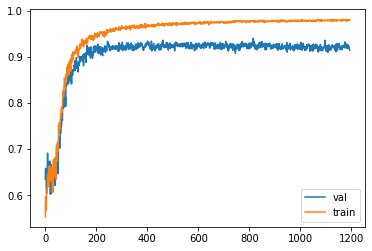

train 0.9795235976862449
val 0.9139189352140635



KeyboardInterrupt: ignored

In [0]:
history_train = []
history_val = []
history_train_roc = []
epochs = 400
optim = torch.optim.Adam(model.parameters())
loss_function = nn.BCELoss().to(device)
train_df_for_roc = train_df.sample(int(train_df.shape[0] * 0.3))
train_df_roc = trainer.make_batch(train_df_for_roc)
valid_df_roc = trainer.make_batch(valid_df)


for epoch in range(epochs):
    for idx, (batch, target) in tqdm_notebook(enumerate(trainer.iterable_minibatches(train_df))):
        # input_site = torch.FloatTensor(batch['sites']).cuda()
        input_cat = torch.tensor(batch['cat'], dtype=torch.long).float().cuda()
        input_cluster = torch.tensor(batch['cluster'], dtype=torch.long).float().cuda()
        target = torch.tensor(target).float().to(device)

        predictions = model(input_cat, input_cluster).float()
        predictions = predictions.view(predictions.size(0))
        loss = loss_function(predictions, target)

        loss.backward()
        optim.step()
        optim.zero_grad()


        history_train.append(loss.data.cpu().numpy())
        if (idx+1)%5 == 0:
            history_val.append(roc_auc(model, valid_df, batch = valid_df_roc))
            history_train_roc.append(roc_auc(model, train_df_for_roc, batch = train_df_roc,prob = 1))
        if (idx+1)%50==0:
            clear_output(True)
            plt.plot(history_val,label='val')
            plt.plot(history_train_roc, label = 'train')
            plt.legend()
            plt.show()
            print(f'train {history_train_roc[-1]}')
            print(f'val {history_val[-1]}')

In [0]:
trainer.make_predictions_file(model)

In [0]:
np.max(history_val)

0.9397362890054176

In [0]:
vectorizer = TfidfVectorizer(tokenizer = lambda s: s.split(';#'),
                             analyzer = 'word')
corpus = list(map(';#'.join, data[sites].values))

In [0]:
tf_idf_matrix = vectorizer.fit_transform(corpus)
features_name = vectorizer.get_feature_names()
# mean_target =  np.array(list(map(get_tf_idf_representation, data[data['target'] == 1][['index_norm'] + sites].values)))
# mean_no_target = np.array(list(map(get_tf_idf_representation, data[data['target'] == 0][['index_norm'] + sites].sample(5000).values)))

In [0]:
def get_tf_idf_repr(col_num, col_name):
  vect = torch.Tensor(model_ft[col_name]).cuda()
  return torch.Tensor(tf_idf_matrix[:, col_num].toarray()).cuda() * vect

In [0]:
a = []
for col_num in range(tf_idf_matrix.shape[1]):
  col_name = features_name[col_num]
  if len(a) == 0:
    a = get_tf_idf_repr(col_num, col_name)
  else:
    a += get_tf_idf_repr(col_num, col_name)
  if col_num % 1000 == 0:
    print(col_num)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000


In [0]:
pd.DataFrame(a.cpu().data.numpy()).to_csv('drive/My Drive/tf_idf_embeddings.csv', index = False)

In [0]:
mean_no_target = np.array(list(map(get_vector,train_df[train_df['target'] == 0][sites].sample(20000).values))).mean(axis = 1)
mean_target = np.array(list(map(get_vector,train_df[train_df['target'] == 1][sites].values))).mean(axis = 1)

In [0]:
tsne = TSNE(n_components = 2)
mean_no_target_transform = tsne.fit_transform(mean_no_target)
mean_target_transform = tsne.fit_transform(mean_target)
mean_target_transform = StandardScaler().fit_transform(mean_target_transform)
mean_no_target_transform = StandardScaler().fit_transform(mean_no_target_transform)

In [0]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, x_target = None, y_target = None, radius=10, alpha=0.25, color='blue',
                 color_target = 'red',
                 width=600, height=400, show=True, **kwargs):
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })
    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    if x_target is not None and y_target is not None:
      color_red = [color_target] * len(x_target)
      data_source_target = bm.ColumnDataSource({ 'x' : x_target, 'y' : y_target, 'color': color_red, **kwargs })
      fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source_target)

    # fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [0]:
draw_vectors(mean_no_target_transform[:, 0], mean_no_target_transform[:, 1], x_target = mean_target_transform[:, 0],
             y_target = mean_target_transform[:, 1])

Figure(id='1109', ...)

In [0]:
words_target_vectors_transform.shape

(1026, 2)

In [0]:
results_dict = {}
for num_clusters in range(5, 50, 5):
  k_means = KMeans(n_clusters = num_clusters, random_state = 10).fit(train_df[mean_embedding])
  train_df['clustering'] = k_means.predict(train_df[mean_embedding])
  results_dict[num_clusters] = train_df[['clustering', 'target']].groupby(['clustering']).mean().std()
  print(num_clusters)
  print(data[['clustering', 'target']].groupby(['clustering']).mean())

In [0]:
corpus = list(map(';#'.join, data[sites].values))

In [0]:
tf_idf_matrix = vectorizer.fit_transform(corpus)

In [0]:
features_name = vectorizer.get_feature_names()

In [0]:
tf_idf_matrix[1, features_name.index('mts0.google')]

0.46255368340326614

In [0]:
data[sites].head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
0,rr.office.microsoft,padding,padding,padding,padding,padding,padding,padding,padding,padding
1,maps.google,mts0.google,khms0.google,mts0.google,mts1.google,khms1.google,khms0.google,khms1.google,193.164.197.30,193.164.196.60
2,cbk1.googleapis,accounts.google,cbk0.googleapis,cbk1.googleapis,twitter,accounts.google,cbk0.googleapis,cbk0.googleapis,cbk0.googleapis,cbk0.googleapis
3,annotathon,annotathon,annotathon,annotathon,annotathon,annotathon,annotathon,annotathon,annotathon,annotathon
4,apis.google,fr.wikipedia,bits.wikimedia,meta.wikimedia,fr.wikipedia,meta.wikimedia,bits.wikimedia,fr.wikipedia,fr.wikipedia,meta.wikimedia
